# pyGAM Quickstart: TAVG PCA Coefficients

Fit smooth additive models to the TAVG PCA coefficients prepared in `GAMsForWeather/tavg_gams_prep.ipynb`. We scale predictors, optionally subsample, train `LinearGAM` models for the first three PCs, and inspect partial dependence plus model fit.


In [19]:
from pathlib import Path
import pickle

PCA_RESULTS_DIR = Path("../../weather_info/pca_results").resolve()
TAVG_PCA_PATH = PCA_RESULTS_DIR / "tavg_pca_results.pkl"
with TAVG_PCA_PATH.open("rb") as fh:
    tavg_pca = pickle.load(fh)

tavg_mean = tavg_pca["mean"]
tavg_components = tavg_pca["components"]



In [20]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygam import LinearGAM, s

DATA_PATH = Path("/home/yfreund/weather_data/per_row_coefficients.parquet").resolve()

In [22]:
predictor_cols = ["latitude", "dist_to_coast", "elevation"]
component_cols = ["PC1", "PC2", "PC3", "PC4", "PC5"]

tavg_df = pd.read_parquet(DATA_PATH)
if "ELEMENT" in tavg_df.columns:
    tavg_df = tavg_df[tavg_df["ELEMENT"] == "TAVG"].reset_index(drop=True)
elif "element" in tavg_df.columns:
    tavg_df = tavg_df[tavg_df["element"] == "TAVG"].reset_index(drop=True)



In [23]:
days = np.arange(1, len(tavg_mean) + 1)



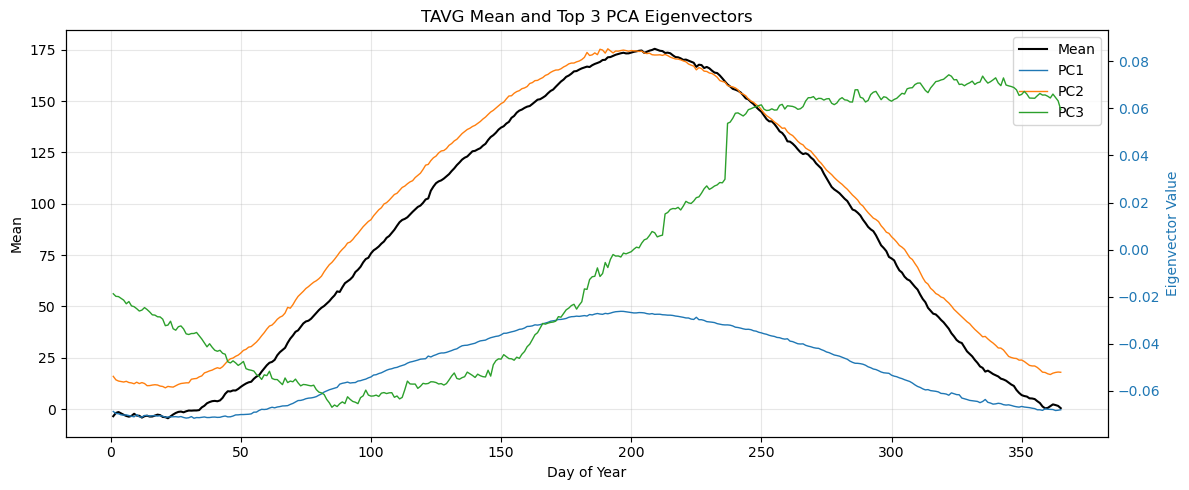

In [ ]:

fig, ax_mean = plt.subplots(figsize=(12, 5))

line_mean = ax_mean.plot(days, tavg_mean, color="black", linewidth=1.5, label="Mean")
ax_mean.set_xlabel("Day of Year")
ax_mean.set_ylabel("Mean", color="black")
ax_mean.tick_params(axis="y", labelcolor="black")
ax_mean.grid(True, alpha=0.3)

ax_pc = ax_mean.twinx()
pc_colors = ["tab:blue", "tab:orange", "tab:green"]
pc_lines = []
for idx, color in enumerate(pc_colors, start=1):
    line = ax_pc.plot(days, tavg_components[idx - 1], color=color, linewidth=1.0, label=f"PC{idx}")
    pc_lines.extend(line)

ax_pc.set_ylabel("Eigenvector Value", color="tab:blue")
ax_pc.tick_params(axis="y", labelcolor="tab:blue")

lines = line_mean + pc_lines
labels = [line.get_label() for line in lines]
ax_mean.legend(lines, labels, loc="upper right")
ax_mean.set_title("TAVG Mean and Top 3 PCA Eigenvectors")
fig.tight_layout()
plt.show()



In [25]:
available_components = [col for col in component_cols if col in tavg_df.columns]

if not available_components:
    raise ValueError("No PCA component columns were found in the coefficient dataset")

available_components = available_components[:3]

tavg_df = tavg_df.dropna(subset=predictor_cols + available_components).copy()
tavg_df[predictor_cols + available_components] = tavg_df[predictor_cols + available_components].astype(float)
tavg_df = tavg_df[predictor_cols + available_components]
tavg_df.head()


,latitude,dist_to_coast,elevation,PC1,PC2,PC3
0,41.117,221.167,1509.0,1181.187658,-1628.747705,-91.175263
1,41.117,221.167,1509.0,1233.941454,-1588.863613,-64.689131
2,41.117,221.167,1509.0,1115.967543,-1432.061767,-142.679642
3,41.117,221.167,1509.0,1122.428958,-1504.756770,-29.399955
4,41.117,221.167,1509.0,1168.601544,-1475.255536,-57.378708


In [26]:
X = tavg_df[predictor_cols].to_numpy()


In [27]:
sample_size = 100_000
rng = np.random.default_rng(0)

if len(X) > sample_size:
    idx = rng.choice(len(X), size=sample_size, replace=False)
    X_sample = X[idx]
    df_sample = tavg_df.iloc[idx].reset_index(drop=True)
else:
    X_sample = X
    df_sample = tavg_df.reset_index(drop=True)

X_sample = np.asarray(X_sample, dtype=float)
X_sample.shape, df_sample.shape


((100000, 3), (100000, 6))

In [28]:
  import scipy.sparse as sps   # a patch to deal with sparsee matrices
  if not hasattr(sps.spmatrix, "A"):
      sps.spmatrix.A = property(lambda self: self.toarray())

In [29]:
models = {}
for component in available_components:
    y = df_sample[component].to_numpy(dtype=float)
    gam = LinearGAM(s(0) + s(1) + s(2)).gridsearch(X_sample, y, progress=False)
    models[component] = gam
    pseudo_r2 = gam.statistics_.get("pseudo_r2", float("nan"))
    if isinstance(pseudo_r2, dict):
        pseudo_r2 = next(iter(pseudo_r2.values()))
    print(f"{component}: pseudo-R^2={float(pseudo_r2):.3f}")


PC1: pseudo-R^2=0.724
PC2: pseudo-R^2=0.441
PC3: pseudo-R^2=0.079


In [16]:
metrics = []
for comp in available_components:
    y_true = df_sample[comp].to_numpy(dtype=float)
    preds = models[comp].predict(X_sample)
    residuals = y_true - preds

    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res / ss_tot if ss_tot else float("nan")

    mae = np.mean(np.abs(residuals))
    rmse = np.sqrt(np.mean(residuals**2))
    pseudo_r2 = models[comp].statistics_.get("pseudo_r2", float("nan"))
    if isinstance(pseudo_r2, dict):
        pseudo_r2 = next(iter(pseudo_r2.values()))

    metrics.append(
        {
            "Component": comp,
            "R2": r2,
            "Pseudo_R2": float(pseudo_r2),
            "MAE": mae,
            "RMSE": rmse,
        }
    )

metrics_df = pd.DataFrame(metrics).set_index("Component")
metrics_df.loc["Average"] = metrics_df.mean(numeric_only=True)
metrics_df.round(4)



,R2,Pseudo_R2,MAE,RMSE
Component,,,,
PC1,0.7244,0.7244,715.8027,964.4488
PC2,0.4414,0.4414,452.0041,641.0479
PC3,0.0790,0.0790,193.3775,325.4679
Average,0.4150,0.4150,453.7281,643.6549


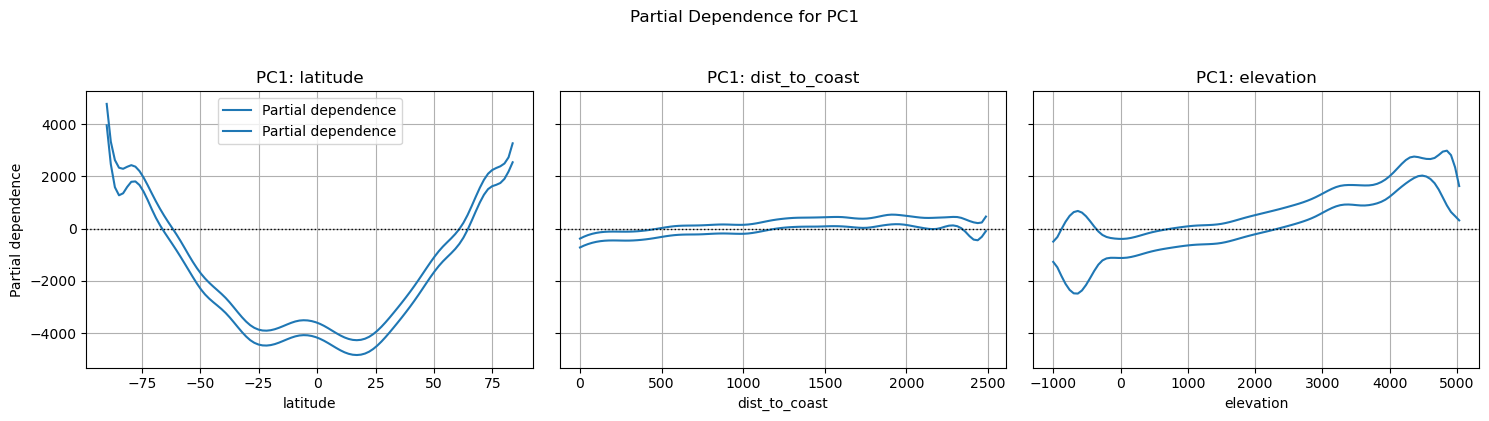

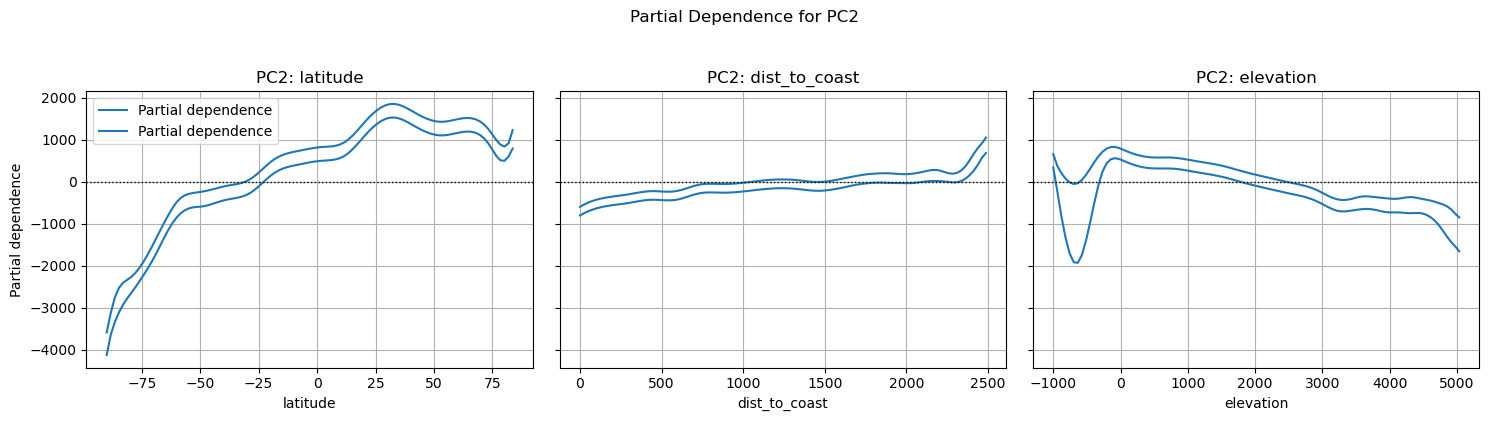

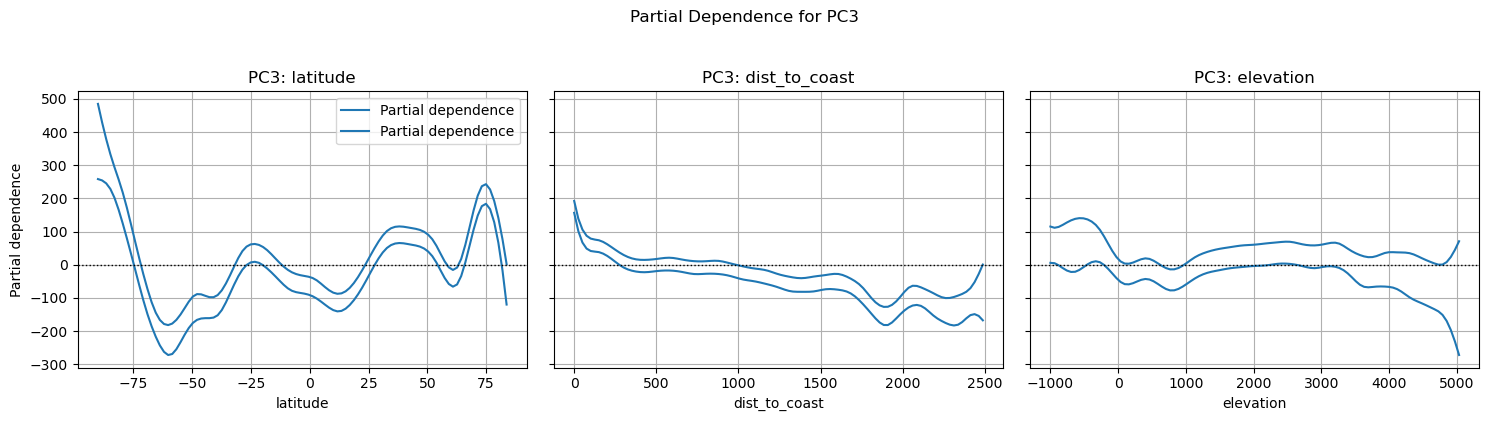

In [33]:
for component in available_components:
    gam = models[component]
    fig, axes = plt.subplots(1, len(predictor_cols), figsize=(15, 4), sharey=True)

    for term, ax in enumerate(axes):
        XX = gam.generate_X_grid(term=term)
        pd_result = gam.partial_dependence(term=term, X=XX, width=0.95)
        if len(pd_result) == 3:
            _, pdep, confi = pd_result
            is_ci_tuple = True
        else:
            _, pdep = pd_result
            is_ci_tuple = False

        ax.plot(XX[:, term], pdep, color="tab:blue", label="Partial dependence")
        if is_ci_tuple:
            ax.fill_between(XX[:, term], confi[0], confi[1], color="tab:blue", alpha=0.2, label="95% CI")

        ax.set_title(f"{component}: {predictor_cols[term]}")
        ax.set_xlabel(predictor_cols[term])
        ax.grid(True)
        ax.axhline(0, color="k", linestyle=":", linewidth=1)

        if term == 0:
            ax.legend(loc="best")

    axes[0].set_ylabel("Partial dependence")
    fig.suptitle(f"Partial Dependence for {component}", y=1.04)
    fig.tight_layout()
    plt.show()


## Partial dependence Graphs
Partial dependence isolates a single predictor’s effect on a model’s output. You sweep a feature through its range, hold every other feature at their observed values (or a chosen baseline), ask the model for predictions at each sweep point, and average those predictions. The resulting curve shows how the model’s expectation changes as that one feature varies, assuming the rest stay typical.

Upper and lower partial-dependence curves often accompany the main line. They can represent confidence bounds (e.g., ±1.96 × standard error) showing uncertainty in the estimated effect, or scenario envelopes where other predictors are fixed at high or low quantiles to illustrate interaction-driven shifts. Read them as a band around the central effect, signaling how the modeled response might move under plausible variation.

In [18]:
r2_results = {}
for comp in available_components:
    y_true = df_sample[comp].to_numpy(dtype=float)
    preds = models[comp].predict(X_sample)
    ss_res = np.sum((y_true - preds) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot
    r2_results[comp] = r2
    print(f"{comp}: R^2 = {r2:.3f}")

r2_df = pd.DataFrame.from_dict(r2_results, orient="index", columns=["R2"])
r2_df.loc["Average"] = r2_df["R2"].mean()
r2_df


PC1: R^2 = 0.724
PC2: R^2 = 0.441
PC3: R^2 = 0.079


,R2
PC1,0.724398
PC2,0.441438
PC3,0.079039
Average,0.414958


In [35]:
for pc in available_components:
    print('='*100,pc)
    print(pc)
    models[pc].summary()

==================================================================================================== PC1
PC1
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      56.418
Link Function:                     IdentityLink Log Likelihood:                              -1466261.7163
Number of Samples:                       100000 AIC:                                          2932638.2686
                                                AICc:                                         2932638.3357
                                                GCV:                                           931632.6581
                                                Scale:                                         930686.6104
                                   

/tmp/ipykernel_2319938/1408068125.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  models[pc].summary()


### p-values
n the GAM summary, those “p > x” entries come from likelihood-ratio-style tests. The idea: fit the full model, then fit a restricted version with a term (say s(latitude)) shrunk to zero. Compare their log-likelihoods; the difference, scaled by 2, follows a χ² distribution under the null. The reported p-value is the tail probability of that χ² statistic. So it asks, “is the drop in fit if I remove this smooth larger than I’d expect by chance?” Because the smoothing parameters are themselves estimated, the χ² reference isn’t exact—hence pyGAM’s warning that the p-values are too small and should be treated as indicative only.